In [1]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in xrange(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days
Using gpu device 0: GeForce GTX 780 (CNMeM is disabled)

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 1.047394 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [2]:
%pylab inline
import lasagne

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
from __future__ import print_function

In [4]:
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

In [5]:
import numpy as np
import theano
import theano.tensor as T

In [6]:
import time
import sys

In [7]:
from fuel.datasets.cifar10 import CIFAR10

In [16]:
from common.plotting import plot_mat

In [17]:
CIFAR10(("train",)).num_examples

50000

In [18]:
OFFSET = 40000

In [19]:
cifar_train = CIFAR10(("train",), subset=slice(None, OFFSET))

In [20]:
features = cifar_train.data_sources[0]

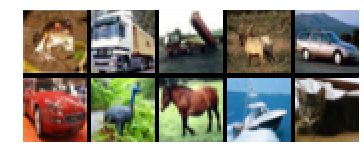

In [21]:
plot_mat((features[:100])[:10])

In [22]:
train_scale = 1.0 / abs(features).max()

In [23]:
train_shift = - features.mean(0) * train_scale

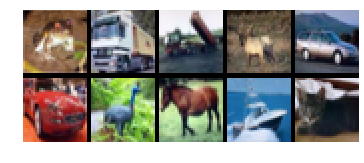

In [24]:
plot_mat((features[:100] * train_scale + train_shift)[:10])

In [25]:
CIFAR10.default_transformers = (
    (ScaleAndShift, [], {"scale":train_scale, "shift": train_shift, "which_sources":"features"}),
    (Cast, [], {"dtype":"float32", "which_sources":"features"})
)

In [26]:
def normalize_stream(stream):
    normalized = ScaleAndShift(data_stream = stream,
                              scale=train_scale, shift=train_shift,
                              which_sources=('features',))
    return Cast(data_stream=normalized,
               dtype='float32', which_sources=('features',))

In [27]:
#this stream will shuffle the CIFAR set and return us batches of 100 examples
not_normalized_train_stream = DataStream.default_stream(
    cifar_train,
    iteration_scheme=ShuffledScheme(cifar_train.num_examples, 100))

# cifar_train_stream = normalized(not_normalized_train_stream)
cifar_train_stream = not_normalized_train_stream

In [28]:
cifar_inverse_train_stream = ScaleAndShift(
    data_stream=cifar_train_stream,
    scale=float32(-1),
    shift=int32(0),
    which_sources=('features'))

In [29]:
from common.plotting import plot_mat

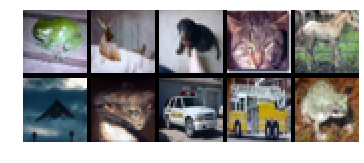

In [30]:
it = not_normalized_train_stream.get_epoch_iterator()
plot_mat(next(it)[0][:10])

0.0548213


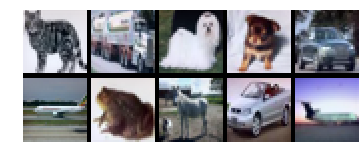

In [31]:
it = cifar_train_stream.get_epoch_iterator()
plot_mat(next(it)[0][:10])
ex = next(it)[0][0]
print(next(it)[0].mean(0).max())

0.0684728


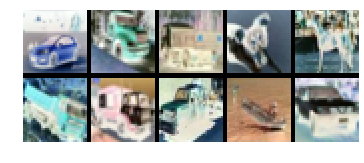

In [32]:
it = cifar_inverse_train_stream.get_epoch_iterator()
plot_mat(next(it)[0][:10])
ex = next(it)[0][0]
print(next(it)[0].mean(0).max())

In [33]:
cifar_train_stream.reset()
cifar_inverse_train_stream.reset()

In [34]:
print("The streams return batches containing %s" % (cifar_train_stream.sources,))

print("Each training batch consits of a tuple containing:")
for element in next(cifar_train_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))

The streams return batches containing (u'features', u'targets')
Each training batch consits of a tuple containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8


In [35]:
cifar_validation = CIFAR10(("train",), subset=slice(OFFSET, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
#cifar_validation_stream = normalize_stream(
#    DataStream.default_stream(cifar_validation,
#                              iteration_scheme=SequentialScheme(cifar_validation.num_examples, 250))#)
cifar_validation_stream = DataStream.default_stream(cifar_validation,
                              iteration_scheme=SequentialScheme(cifar_validation.num_examples, 250))
cifar_test = CIFAR10(("test",))
#cifar_test_stream = normalize_stream(
#    DataStream.default_stream(cifar_test,
#                              iteration_scheme=SequentialScheme(cifar_test.num_examples, 250))#)
cifar_test_stream = DataStream.default_stream(cifar_test,
                              iteration_scheme=SequentialScheme(cifar_test.num_examples, 250))

In [36]:
print("Validation/test batches consits of tuples containing:")
for element in next(cifar_test_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))

Validation/test batches consits of tuples containing:
 - an array of size (250, 3, 32, 32) containing float32
 - an array of size (250, 1) containing uint8


In [37]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

In [38]:
learning_rate = T.scalar('learning_rate')
momentum = T.scalar('momentum')

In [39]:
l_in = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),
                                     input_var=input_var)

In [84]:
parameters = {
    'nonlinear_units_big' : 800,
    'nonlinear_units_small' : 256,
    'dropout_small' : .3,
    'dropout_big' : .6,
    'learning_rate' : learning_rate, 
    # (.01 -> .005 -> .001)
    'momentum' : momentum,
    # -> (.9 -> .6 -> .4) .9 seems too harsh (net overshoots a lot)
    'num_filters' : 32,
    'filter_size' : (5,5), # over (5,5) decrease net capabilities
    'pool_size' : (2,2) # keep this (2,2) -> how much we need to scale before MLP
}

In [85]:
def network_combinator(in_layer, layers):
    for layer_def in layers:
        in_layer = layer_def[0](in_layer, **layer_def[1])
    return in_layer

In [86]:
def final_layer(l_in):
    return network_combinator(l_in,[
            ( lasagne.layers.DenseLayer, {
                    'num_units'  : 10,
                    'nonlinearity' : lasagne.nonlinearities.softmax })
        ])

In [87]:
dropout = lambda p:  ( lasagne.layers.DropoutLayer, { 'p' : p } )
dense_nonlinear = lambda u:  ( lasagne.layers.DenseLayer, {
                'nonlinearity' : lasagne.nonlinearities.rectify,
                'num_units' : u,
            })
conv2d = lambda f, s: ( lasagne.layers.Conv2DLayer, {
        'num_filters' : f,
        'filter_size' : s,
        'nonlinearity' : lasagne.nonlinearities.rectify,
        'pad' : 'full'
        })


maxpool2d = lambda s: ( lasagne.layers.MaxPool2DLayer, {
        'pool_size' : s
    })

In [88]:
def mlp(l_in):
    nlub = parameters['nonlinear_units_big']
    nlus = parameters['nonlinear_units_small']
    ds = parameters['dropout_small']
    db = parameters['dropout_big']
    return network_combinator(l_in,[
            dropout(db),
            dense_nonlinear(nlus),
            dropout(ds),
            dense_nonlinear(nlub),
            dropout(db),
            dense_nonlinear(nlub),
            dropout(db)
        ])

In [89]:
def cnn(l_in):
    nfilt = parameters['num_filters']
    filts = parameters['filter_size']
    pools = parameters['pool_size']
    ds = parameters['dropout_small']
    db = parameters['dropout_big']
    
    return network_combinator(l_in, [
            conv2d(nfilt, filts),
            maxpool2d(pools),
            dropout(ds),
            conv2d(nfilt, filts),
            maxpool2d(pools)
        ])

In [90]:
network = l_in
network = cnn(network)
network = mlp(network)
network = final_layer(network)

In [91]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

In [92]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=parameters['learning_rate'], momentum=parameters['momentum'])

In [93]:
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

In [94]:
train_fn = theano.function([input_var, target_var, learning_rate, momentum], [loss, test_acc], updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [95]:
def train(train_stream, validation_stream, num_epochs, f=sys.stdout, lr=0.1, mo=0.2):
    for epoch in xrange(num_epochs):
        train_err = 0
        train_batches = 0
        train_acc = 0
        start_time = time.time()
        for inputs, targets in train_stream.get_epoch_iterator():
            err, acc = train_fn(inputs, targets.ravel(), lr, mo)
            train_batches += 1
            train_acc += acc
            train_err += err

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for inputs, targets in validation_stream.get_epoch_iterator():
            err, acc = val_fn(inputs, targets.ravel())
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("  epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time),
            file=f)
#        print("  training loss:\t\t{:.6f}".format(train_err / train_batches)
#              , file=f)
        print("  train accuracy:\t\t{:.2f} %".format(
            train_acc / train_batches * 100)
              , file=f)
#        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches)
#              , file=f)
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100)
              , file=f)
        f.flush()

In [96]:
train(cifar_train_stream, cifar_validation_stream, 1)

  epoch 1 of 1 took 30.555s
  train accuracy:		21.96 %
  validation accuracy:		30.22 %


In [ ]:
f = open('workfile', 'w', 0)
try:
    for i in range(100):
        lr = 0.01*0.1**(i/100.)
        mo = 0.9
        print("Iteration: {}, learning_rate {}".format(i, lr), file=f)
        train(cifar_inverse_train_stream, cifar_validation_stream, 10, f = f, lr=lr, mo=mo)
        train(cifar_train_stream, cifar_validation_stream, 10, f = f, lr = lr, mo=mo)
    for j in range(50):
        k = i+j
        lr = 0.01*0.1**(k/100.)
        mo = 0.9
        print("Iteration: {}, learning_rate {}".format(k, lr), file=f)
        train(cifar_train_stream, cifar_validation_stream, 1, f = f, lr = lr, mo=mo)
finally:
    f.close()

In [128]:
val_acc = 0
batches = 0
for inputs, targets in cifar_test_stream.get_epoch_iterator():
    _, acc = val_fn(inputs, targets.ravel())
    val_acc += acc
    batches += 1
print("  train accuracy:\t\t{:.2f} %".format(
    val_acc / batches * 100))

  train accuracy:		77.35 %


In [51]:
import pickle
f = open('parameters', 'w')
try:
    pickle.dump(network, f)
finally:
    f.close()

In [52]:
import numpy
numpy.save('nparameters', network)

In [61]:
prediction_fn = theano.function(
    [input_var],
    T.argmax(lasagne.layers.get_output(network, deterministic=True), axis=1))

In [64]:
f = open('logfile', 'w', 0)
try:
    for inputs, targets in cifar_test_stream.get_epoch_iterator():
        for i, j in zip(prediction_fn(inputs), targets.ravel()):
            print(i,j, file=f)
finally:
    f.close()
